In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn import metrics # # from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

import modelEvalUtils as meu

# %config InlineBackend.figure_formats = ['svg']
%matplotlib inline

plt.rcParams['figure.figsize'] = (9, 6)
sns.set(context='notebook', style='whitegrid', font_scale=1.2)

In [2]:
base_df = pd.read_csv("../Data/clinvar_conflicting.csv", dtype={"CHROM": "string", "MOTIF_NAME": "string", "HIGH_INF_POS": "string"})

In [3]:
base_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 46 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CHROM               65188 non-null  string 
 1   POS                 65188 non-null  int64  
 2   REF                 65188 non-null  object 
 3   ALT                 65188 non-null  object 
 4   AF_ESP              65188 non-null  float64
 5   AF_EXAC             65188 non-null  float64
 6   AF_TGP              65188 non-null  float64
 7   CLNDISDB            65188 non-null  object 
 8   CLNDISDBINCL        167 non-null    object 
 9   CLNDN               65188 non-null  object 
 10  CLNDNINCL           167 non-null    object 
 11  CLNHGVS             65188 non-null  object 
 12  CLNSIGINCL          167 non-null    object 
 13  CLNVC               65188 non-null  object 
 14  CLNVI               27659 non-null  object 
 15  MC                  64342 non-null  object 
 16  ORIG

In [4]:
# reduce the data frame and do some basic cleaning, start with just a few bare features

# features to test first:
#     - CHROM, REF, ALT, AF_*, CLNVC, ORIGIN, CLASS, Allele, Consequence, IMPACT, STRAND

# features which don't seem to be super useful (maybe they would be when all together)
# CHROM, REF, ALT, CLNVC, ORIGIN, Consequence, IMPACT (seems like this should be at a least a little useful), STRAND

# test_var = 'STRAND'

# select features
# reduced_df = base_df[['CLASS', 'CHROM']]
# reduced_df = base_df[['CLASS', 'CHROM', 'REF', 'ALT']]
reduced_df = base_df[['CLASS', 'CHROM', 'REF', 'ALT', 'CLNVC', 'ORIGIN', 'Consequence', 'IMPACT', 'STRAND']]
# reduced_df = base_df[['CLASS', 'CHROM', 'REF', 'ALT', 'Consequence', test_var]]
# reduced_df = base_df[['CLASS', 'CHROM', 'REF', 'ALT', test_var]]

# feature cleaing/adjustment below here

# CHROM - turn CHROM strings into numbers
reduced_df.loc[reduced_df['CHROM'] == 'X', 'CHROM'] = '23'
reduced_df.loc[reduced_df['CHROM'] == 'MT', 'CHROM'] = '24'
reduced_df["CHROM"] = pd.to_numeric(reduced_df["CHROM"])

# dropping MT rows (after it was converted to 24)
# reduced_df.drop(reduced_df[reduced_df['CHROM'] == 24].index, inplace=True)

# REF, ALT - lots of alleles with more than one type, combine them all as "2+" instead of dropping them like below
reduced_df.loc[reduced_df['REF'].str.len() > 1, 'REF'] = '2+'
reduced_df.loc[reduced_df['ALT'].str.len() > 1, 'ALT'] = '2+'
# drop rows where REF is not one of the main 4 (for others there are not many rows, could maybe combine them though in the future somehow)
# main_alleles = ['C', 'G', 'A', 'T']
# reduced_df = reduced_df[reduced_df['REF'].isin(main_alleles)]

# ORIGIN - combine ORIGIN values if they are more than 1 (too many of them, and they are a sum of the smaller parts, making it difficult to split them out - could try and do that though)
reduced_df['ORIGIN'] = reduced_df['ORIGIN'].astype(str)
reduced_df.loc[reduced_df['ORIGIN'] != '1', 'ORIGIN'] = '1+'
# try dropping most common one to see if there are any trends for the lesser count categories
# reduced_df.drop(reduced_df[reduced_df['ORIGIN'] == 1].index, inplace=True)

# Consequence - drop those with less than 100 counts
reduced_df = reduced_df.groupby('Consequence').filter(lambda x : len(x)>100)

# print('Column type:', type(reduced_df.iloc[0][test_var]))
# print('Num categores:', reduced_df[test_var].nunique())
# with pd.option_context('display.max_rows', 2000):
#     print(reduced_df[test_var].value_counts())


# print(reduced_df['CLASS'].unique())
# print(reduced_df['CLASS'].value_counts())

/Users/NickPC/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
<ipython-input-4-6663d6e59bf5>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_df["CHROM"] = pd.to_numeric(reduced_df["CHROM"])
/Users/NickPC/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

In [5]:
# check categorical variables vs conflicting or not to try and find some predictive features - do this before encoding so there are less plots to make
# for col in reduced_df.columns:
#     if(col == 'CLASS'): continue
#     plt.figure()
#     counts = (reduced_df.groupby(['CLASS'])[col]
#                      .value_counts(normalize=True)
#                      .rename('percentage')
#                      .mul(100)
#                      .reset_index()
#                      .sort_values(col))
#     print(counts)


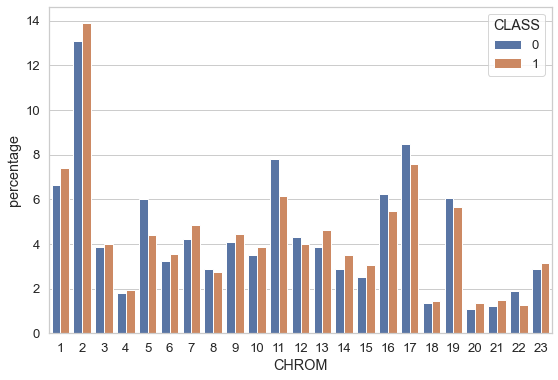

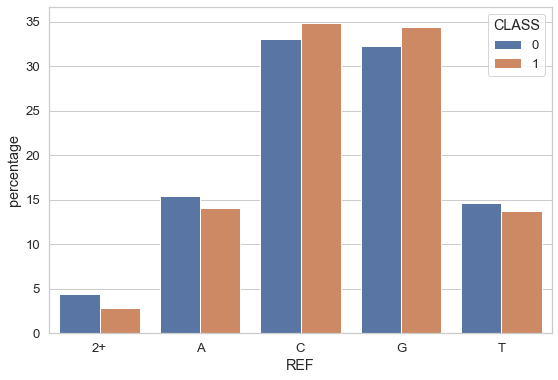

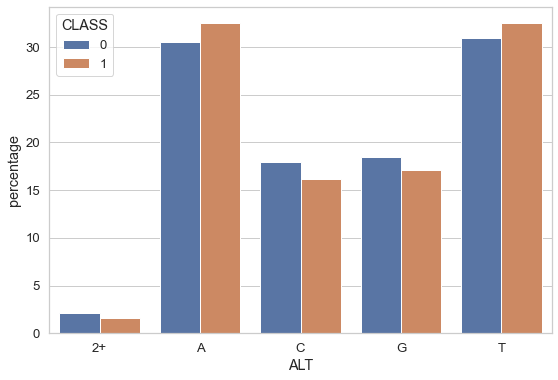

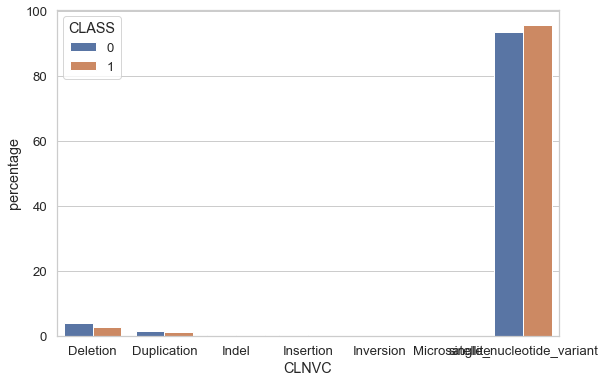

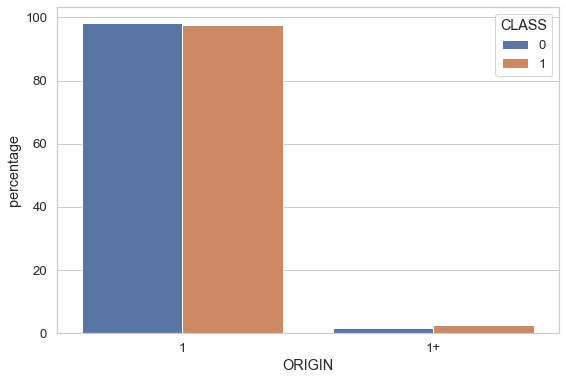

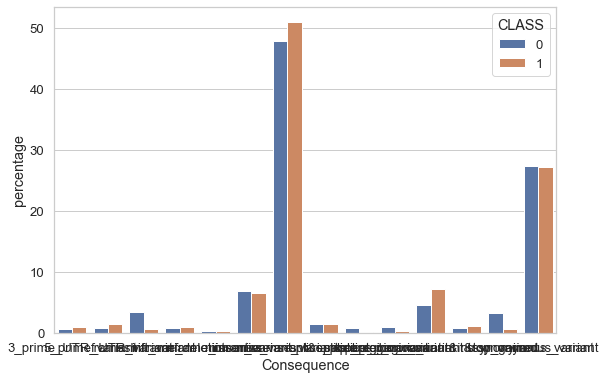

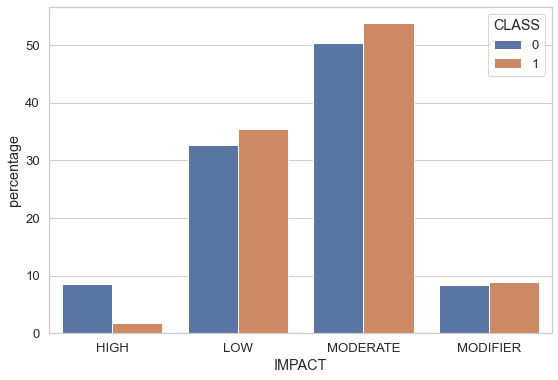

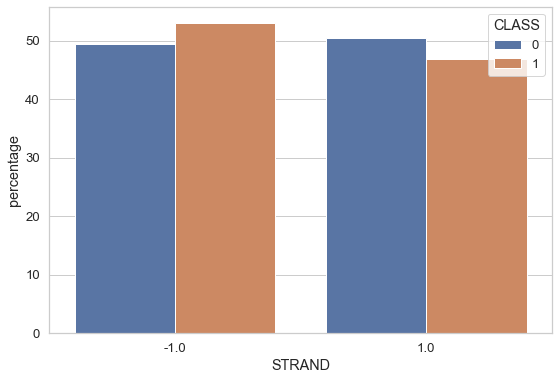

In [6]:
# check categorical variables vs conflicting or not to try and find some predictive features - do this before encoding so there are less plots to make
for col in reduced_df.columns:
    if(col == 'CLASS'): continue
    plt.figure()
    counts = (reduced_df.groupby(['CLASS'])[col]
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values(col))
    sns.barplot(x=col, y="percentage", hue="CLASS", data=counts)


In [7]:
feature_columns = list(reduced_df.columns)
feature_columns.remove('CLASS')
feature_columns.remove('CHROM')
feature_columns

['REF', 'ALT', 'CLNVC', 'ORIGIN', 'Consequence', 'IMPACT', 'STRAND']

In [8]:
# encode REF column 
# encoded_df = pd.get_dummies(reduced_df, prefix=['CHROM', 'REF', 'ALT', test_var], columns=['CHROM', 'REF', 'ALT', test_var])
# encoded_df = pd.get_dummies(reduced_df, prefix=['REF', 'ALT', 'CLNVC', 'ORIGIN', 'Consequence'], columns=['REF', 'ALT', 'CLNVC', 'ORIGIN', 'Consequence'])
# encoded_df = pd.get_dummies(reduced_df, prefix=['REF', 'ALT', 'Consequence', test_var], columns=['REF', 'ALT', 'Consequence', test_var])
# encoded_df = pd.get_dummies(reduced_df, prefix=['REF', 'ALT', test_var], columns=['REF', 'ALT', test_var])
encoded_df = pd.get_dummies(reduced_df, prefix=feature_columns, columns=feature_columns)
encoded_df

,CLASS,CHROM,REF_2+,REF_A,REF_C,REF_G,REF_T,ALT_2+,ALT_A,ALT_C,...,Consequence_splice_region_variant&intron_variant,Consequence_splice_region_variant&synonymous_variant,Consequence_stop_gained,Consequence_synonymous_variant,IMPACT_HIGH,IMPACT_LOW,IMPACT_MODERATE,IMPACT_MODIFIER,STRAND_-1.0,STRAND_1.0
0,0,1,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1
1,0,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,1,0,1,0
2,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
3,0,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
4,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65183,0,23,0,0,0,0,1,0,0,0,...,0,0,0,1,0,1,0,0,1,0
65184,1,23,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
65185,0,23,0,0,1,0,0,0,0,0,...,0,0,0,1,0,1,0,0,1,0
65186,0,23,0,0,0,0,1,0,0,1,...,0,0,0,1,0,1,0,0,1,0


In [9]:
# need to do one-hot-encoding of allele type to turn it into a useful variable
# or can maybe use Pandas built in functions, Pandas.Categorical...

# reduced_df.loc[:, 'REF'] = reduced_df['REF'].astype('category')

# print(reduced_df['REF'].nunique())
# print(reduced_df['REF'].value_counts())

In [10]:
# split data into test and train sets
# df_train, df_test = train_test_split(reduced_df, test_size=0.2, random_state=55)
df_train, df_test = train_test_split(encoded_df, test_size=0.2, random_state=55)

In [11]:
# sns.pairplot(df_train, corner=True, height=1.5, plot_kws={'size': 3}, hue='CLASS');

In [12]:
# sns.kdeplot(df_train['CHROM'], hue=df_train['CLASS'])
# sns.kdeplot(df_train.loc[df_train['CLASS'] == 0, 'CHROM'], color='r')
# sns.kdeplot(df_train.loc[df_train['CLASS'] == 1, 'CHROM'], color='b')

In [13]:
# sns.countplot(df_train.loc[df_train['CLASS'] == 0, 'CHROM'], color='r')
# sns.countplot(df_train.loc[df_train['CLASS'] == 1, 'CHROM'], color='b')

In [14]:
# counts = (df_train.groupby(['CLASS'])['CHROM']
#                      .value_counts(normalize=True)
#                      .rename('percentage')
#                      .mul(100)
#                      .reset_index()
#                      .sort_values('CHROM'))
# p = sns.barplot(x="CHROM", y="percentage", hue="CLASS", data=counts)

In [15]:
# stop

In [16]:
# split out features and target for models

x_train = df_train.drop('CLASS', axis=1)
y_train = df_train['CLASS']

In [17]:
# lm_1 = LogisticRegression(solver='newton-cg',  # For comparison, use the same solver as statsmodels default
#                           C=100000)  # No regularization

# lm_1.fit(x_train, y_train)

In [18]:
# print('intercept: ', round(lm_1.intercept_[0], 4))
# print('chrom coef: ', round(lm_1.coef_[0][0], 4))

In [19]:
# df_eval = df_test.copy()
# df_eval['pred'] = lm_1.predict(x_train)
# df_eval.loc[:, 'pred'] = df_eval['pred'].astype('category')
# df_eval['correct_pred'] = df_eval['pred'] == df_eval['CLASS']

In [20]:
# df_eval.info()
# # df_eval.head(50)
# df_eval['pred'].unique()

In [21]:
# sns.stripplot(data=df_eval,
#               x='CHROM',
#               y='pred',
#               hue='correct_pred',
#               palette={False: '#f03b20', True: '#3182bd'});

In [22]:
# try various models
dummy_model = DummyClassifier(strategy="most_frequent")
knn_model = KNeighborsClassifier(n_neighbors=3)
dt_model = DecisionTreeClassifier(max_depth=4)
rf_model = RandomForestClassifier(n_estimators=10)

models = ["dummy_model", "knn_model", "dt_model", "rf_model"]

Current model is:  dummy_model


/Users/NickPC/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.75      1.00      0.86     38742
           1       0.00      0.00      0.00     13001

    accuracy                           0.75     51743
   macro avg       0.37      0.50      0.43     51743
weighted avg       0.56      0.75      0.64     51743



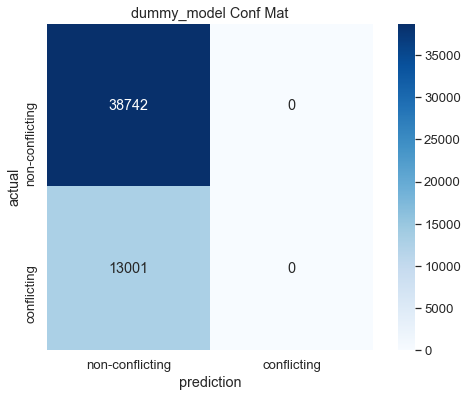

Current model is:  knn_model
              precision    recall  f1-score   support

           0       0.77      0.87      0.82     38742
           1       0.37      0.24      0.29     13001

    accuracy                           0.71     51743
   macro avg       0.57      0.55      0.55     51743
weighted avg       0.67      0.71      0.68     51743



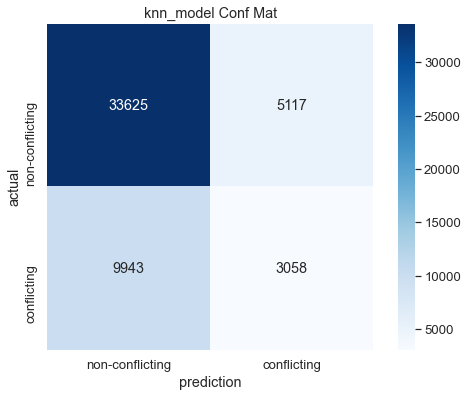

Current model is:  dt_model
              precision    recall  f1-score   support

           0       0.75      1.00      0.86     38742
           1       0.58      0.01      0.01     13001

    accuracy                           0.75     51743
   macro avg       0.67      0.50      0.44     51743
weighted avg       0.71      0.75      0.64     51743



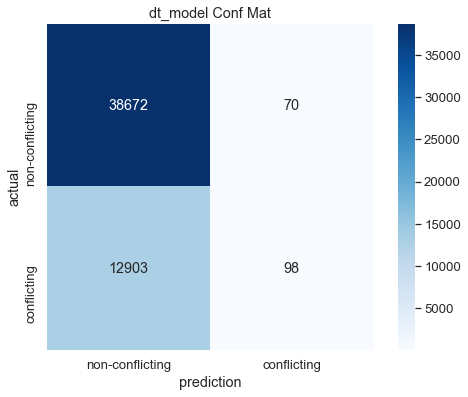

Current model is:  rf_model
              precision    recall  f1-score   support

           0       0.77      0.98      0.86     38742
           1       0.69      0.12      0.21     13001

    accuracy                           0.77     51743
   macro avg       0.73      0.55      0.53     51743
weighted avg       0.75      0.77      0.70     51743



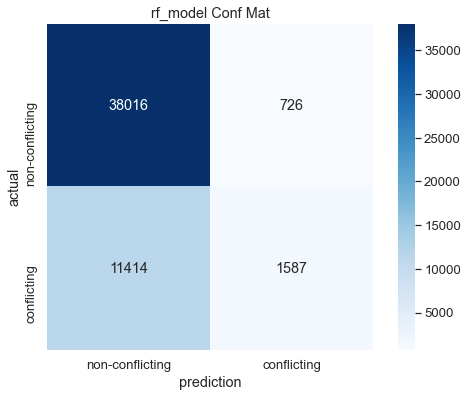

In [23]:
for model_name in models:
    curr_model = eval(model_name)  # The string refers us to the variable
    
    print('Current model is: ', model_name)
    
    curr_model.fit(x_train, y_train)
    y_pred = curr_model.predict(x_train)
    meu.printMetricsAndConfMat(y_train, y_pred, model_name)
    